In [1]:
import os
import sys
# import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sb
from IPython.display import display, HTML

HACKATHON_DATA_PATH = "C:\Hackathon_Data"

In [2]:
complaints_df = pd.read_csv('C:\Hackathon_Data\OFT Data files redacted\OFT Data files redacted\Fair Trading builder complaints data.csv', encoding='ISO-8859-1', error_bad_lines=False)
builder_df = pd.read_csv('C:\Hackathon_Data\PII_Redacted_Extract_Files_20181203\R_BUILDER_EXPORT.txt', encoding='ISO-8859-1', error_bad_lines=False)
policy_df = pd.read_csv('C:\Hackathon_Data\PII_Redacted_Extract_Files_20181203\R_POLICY_EXPORT.txt', encoding='ISO-8859-1', error_bad_lines=False)
elig_df = pd.read_csv('C:\Hackathon_Data\PII_Redacted_Extract_Files_20181203\R_ELIGIBILITY_EXPORT.txt', encoding='ISO-8859-1', error_bad_lines=False)

complaints_df['Licence'] = complaints_df['Licence'].str.lstrip()
complaints_df = complaints_df[complaints_df['Licence'].notna()]

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (15,54,57,59) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
b'Skipping line 197673: expected 109 fields, saw 112\n'
b'Skipping line 365536: expected 109 fields, saw 110\n'
b'Skipping line 414650: expected 109 fields, saw 111\n'
b'Skipping line 424887: expected 109 fields, saw 111\nSkipping line 424888: expected 109 fields, saw 111\n'
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0,2,3,4,5,6,9,10,11,13,17,39,45,48,49,67,68,73,74,76,77,82,86,87,89,90,91,92,93,94,95,96,98,100,101,102,103,104,106,107,108) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
pd.set_option('display.max_columns', None)

elig_df = elig_df[elig_df['current_elig'].notna()]
elig_df = elig_df[elig_df['current_elig'].str.contains('Y')]

print('Merging tables...')
complaints_builder_df = complaints_df.merge(builder_df, left_on='Licence', right_on='builder_bk', how='left')
policy_builder_df = policy_df.merge(builder_df, left_on='builder_bk', right_on='builder_bk', how='left')
builder_df = elig_df.merge(builder_df, left_on='builder_licence_number', right_on='builder_bk', how='left')

print(policy_builder_df.shape)

Merging tables...
(479988, 171)


In [4]:
print('Converting Date Formats')
from pprint import pprint

def parse_policy_dates(series):
    series = series.astype(str).replace('\.0', '', regex=True)
    return pd.to_datetime(series, format='%Y%m%d', errors='coerce')

def get_numeric_stats(series):
    mean = np.mean(series[series.notna()])
    std = np.std(series[series.notna()])
#     print('{}: mean:{:.2f} std:{:.2f}'.format(series.name, mean, std))
    return mean, std

def unpack_value_counts(series, prefix=''):
    counts = series.value_counts(normalize=True, sort=True, ascending=False, bins=None, dropna=True)
    
    out_dict = {}
    for k, v in counts.to_dict().items():
        new_key = '{}{}_{}_proportion'.format(prefix, series.name, k).lower().replace(' ', '_').replace('\\', '_')
        out_dict[new_key] = v
    return out_dict

def normalize(df, columns_to_normalize):
    result = df.copy()
    for feature_name in columns_to_normalize:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result
    
policy_builder_df['issue_date_parsed'] = parse_policy_dates(policy_builder_df['issue_date'])
policy_builder_df['act_completion_date_parsed'] = parse_policy_dates(policy_builder_df['act_completion_date'])
policy_builder_df['est_completion_date_parsed'] = parse_policy_dates(policy_builder_df['est_completion_date'])

policy_builder_df['est_project_duration'] = (policy_builder_df['est_completion_date_parsed'] - policy_builder_df['issue_date_parsed']).dt.days
policy_builder_df['act_project_duration'] = (policy_builder_df['act_completion_date_parsed'] - policy_builder_df['issue_date_parsed']).dt.days

# List of dictionaries
builders_data = []

NUM_BUILDERS_TO_PROCESS = 20

for unique_id in policy_builder_df['builder_bk'][policy_builder_df['builder_bk'].notna()].unique()[:NUM_BUILDERS_TO_PROCESS]:
    print('Aggregating complaints and policy data for builder ID: ' + unique_id)
    builder_data = {'builder_bk': unique_id}
        
    # Get info for this builder
    masked_builder_df = policy_builder_df[policy_builder_df['builder_bk'] == unique_id]
    
    builder_categorical_cols = ['builder_entity_type',
                                'builder_review_size',
                                'builder_review_type',
                                'primary_builder_segment_code',
                                'secondary_builder_segment_code']
    
#     display(masked_builder_df)
    for colname in builder_categorical_cols:
        builder_data[colname] = masked_builder_df[colname].iloc[0]
    
    # Aggregate the policy data for this builder
    masked_policy_builder_df = policy_builder_df[policy_builder_df['builder_bk'] == unique_id]
    
    # Numeric policy Data
    numeric_cols = ['est_project_duration',
                    'act_project_duration',
                    'contract_amount',
                    'approvedjobnumberlimit',
                    'approvedjobnumbervalue']
    
    for colname in numeric_cols:
        builder_data['mean_{}'.format(colname)], builder_data['std_{}'.format(colname)] = get_numeric_stats(masked_policy_builder_df[colname])
    
    # Categorical policy Data
    categorical_cols = ['cover_type',
        'security_type',
        'relationship_to_builder',
        'speculative_project',
        'architectordesigner_tendered',
        'builder_licence_status_code']
    
    for colname in categorical_cols:
        builder_data.update(unpack_value_counts(masked_policy_builder_df[colname]))
            

    # Aggregate the complaint data for this builder
    masked_complaint_builder_df = complaints_builder_df[complaints_builder_df['builder_bk'] == unique_id]
    masked_complaint_builder_df['Date'] = pd.to_datetime(masked_complaint_builder_df['Registered Date'], format='%d/%m/%y %H:%M')
    masked_complaint_builder_df = masked_complaint_builder_df[['Goods', 'Product', 'Practice', 'Date', 'Customer PC']].sort_values(by='Date')
    
    complaint_counts = normalize(masked_complaint_builder_df[['Date', 'Practice']].groupby(pd.Grouper(key='Date', freq='M')).count(), ['Practice'])
    
#     try:
#         ax = complaint_counts.plot(legend=False)
#         ax.set_ylabel('Normalised number of complaints')
#         ax.set_title('Temporal histogram of complaints for {}'.format(unique_id))
#     except TypeError:
#         print('No complaints for this builder')

    # Categorical complaint data
    builder_data.update(unpack_value_counts(masked_complaint_builder_df['Practice'], prefix='complaint_'))
    builder_data.update(unpack_value_counts(masked_complaint_builder_df['Product'], prefix='complaint_'))
            
    builders_data.append(pd.DataFrame([builder_data], columns=builder_data.keys()))

builder_features_df = pd.concat(builders_data, axis=0).reset_index()

# Fill NaN proportions with zero!
cols_to_fill = [col for col in builder_features_df if col.endswith('_proportion')]
builder_features_df[cols_to_fill] = builder_features_df[cols_to_fill].fillna(0.0)

display(builder_features_df)

Converting Date Formats
Aggregating complaints and policy data for builder ID: 186fdfec273406f224bdef9f6af82efe25f4c68afa6b073f13751dbdb9f77aa3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Aggregating complaints and policy data for builder ID: 618053e26399f2df9fe72ee7d58285669165e44d1df32391b8e41a5e7120be37
Aggregating complaints and policy data for builder ID: b8039ec8909f6d3efde9e7c2a425e60e512bfc05a98f9b24cc3881258f6d58b6
Aggregating complaints and policy data for builder ID: ca3269b0631667529393e011ed5bc89ef3b022db436507c14fbb3d1dcb399092
Aggregating complaints and policy data for builder ID: b8b064eb97abe8d1f075c5ff682f2f9f66a47baef37ce85e9df897339abcce5d
Aggregating complaints and policy data for builder ID: 208711425bab49fc27408cbfd22ee73aa08de41c8e7436f960ec9a006a1a6054
Aggregating complaints and policy data for builder ID: 92b80590e585c7f44d3fceaf02f189f77b50128e6b47e5d40e48b32c776b2c73
Aggregating complaints and policy data for builder ID: 10a685f32db295c867fa48cfaa22b3ea4bada6414f8de064e30f65186296c6a2
Aggregating complaints and policy data for builder ID: 7dfdf07de5b34e544cdb7b77453732f20d2091ff0534d37470309f45a154f10e
Aggregating complaints and policy data f

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,index,architectordesigner_tendered_false_proportion,architectordesigner_tendered_true_proportion,builder_bk,builder_entity_type,builder_licence_status_code_l01_proportion,builder_licence_status_code_l07_proportion,builder_review_size,builder_review_type,complaint_practice_accept_payment_without_intention_to_supply_proportion,complaint_practice_availability_of_goods_parts_repairs_proportion,complaint_practice_bait_advertising_proportion,complaint_practice_cancellations_cooling_off_proportion,complaint_practice_conduct_not_listed_proportion,complaint_practice_defective_goods_proportion,complaint_practice_defective_work_proportion,complaint_practice_delay_proportion,complaint_practice_failure_to_supply_information_documents_proportion,complaint_practice_harassment_coercion_proportion,complaint_practice_high_unknown_fees_and_charges_proportion,complaint_practice_incomplete_proportion,complaint_practice_incomplete_work_proportion,complaint_practice_incorrect_weight_measure_quantity_proportion,complaint_practice_loss_damage_to_customers_property__proportion,complaint_practice_misleading_deceptive_proportion,complaint_practice_misrepresentation_not_listed_proportion,complaint_practice_non_partial_supply_proportion,complaint_practice_overcharging_charges_above_quote_proportion,complaint_practice_pricing_charges_rent_fees_not_listed_proportion,complaint_practice_refunds_proportion,complaint_practice_repairs_maintenance_proportion,complaint_practice_rights_responsibility_not_listed_proportion,complaint_practice_safety_standards_not_listed_proportion,complaint_practice_supply_incorrect_goods_proportion,complaint_practice_unsatisfactory_conduct_proportion,complaint_practice_unsatisfactory_goods_proportion,complaint_practice_unsatisfactory_non_performance_of_service_proportion,complaint_practice_uses_benefits_facilities_features_proportion,complaint_practice_warranties_proportion,complaint_practice_warranties_rights_remedies_proportion,complaint_product_air_conditioning_and_heating_proportion,complaint_product_bathrooms_proportion,complaint_product_bricklaying_services_proportion,complaint_product_carpentry_joinery_proportion,complaint_product_concreting_proportion,complaint_product_construction_(commercial)_proportion,complaint_product_electrical_work_proportion,complaint_product_glazing_services_proportion,complaint_product_house_construction_proportion,complaint_product_insurance_(home_owners_warranty)_proportion,complaint_product_kit_homes_garages_proportion,complaint_product_kitchens_proportion,complaint_product_landscaping_proportion,complaint_product_other_construction_proportion,complaint_product_other_external_proportion,complaint_product_other_internal_proportion,complaint_product_other_solar_proportion,complaint_product_painting_and_decorating_proportion,complaint_product_plumbing_gasfitting_proportion,complaint_product_roofing_proportion,complaint_product_solar_pv_panels_proportion,complaint_product_tender_pre-agreement_proportion,complaint_product_tile_flooring_and_floor_covering_proportion,cover_type_c01_proportion,cover_type_c02_proportion,cover_type_c03_proportion,cover_type_c04_proportion,cover_type_c05_proportion,cover_type_c06_proportion,cover_type_c09_proportion,mean_act_project_duration,mean_approvedjobnumberlimit,mean_approvedjobnumbervalue,mean_contract_amount,mean_est_project_duration,primary_builder_segment_code,relationship_to_builder_false_proportion,relationship_to_builder_true_proportion,secondary_builder_segment_code,security_type_s02_proportion,speculative_project_false_proportion,speculative_project_true_proportion,std_act_project_duration,std_approvedjobnumberlimit,std_approvedjobnumbervalue,std_contract_amount,std_est_project_duration
0,0,1.000000,0.000000,186fdfec273406f224bdef9f6af82efe25f4c68afa6b07...,E03,0.0,1.0,Major Project Home Builder,IMB6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

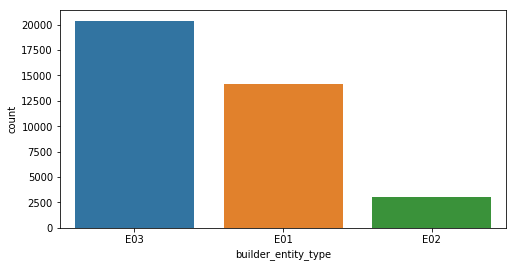

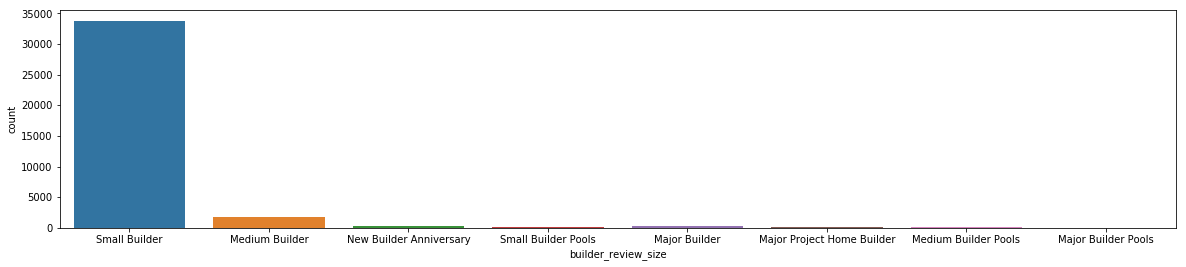

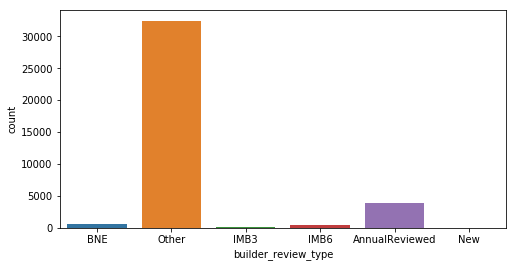

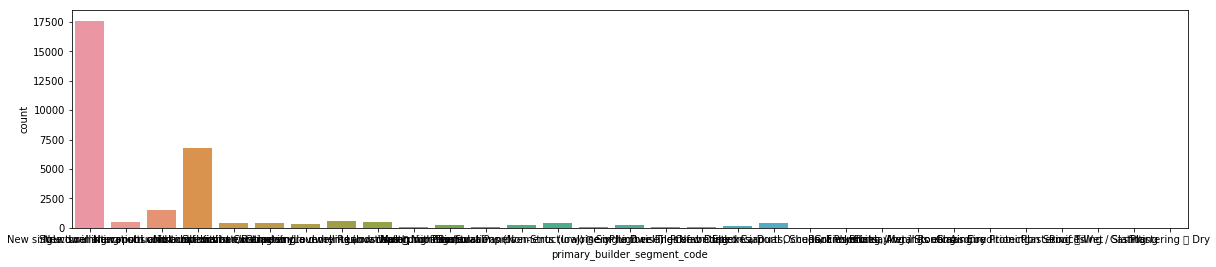

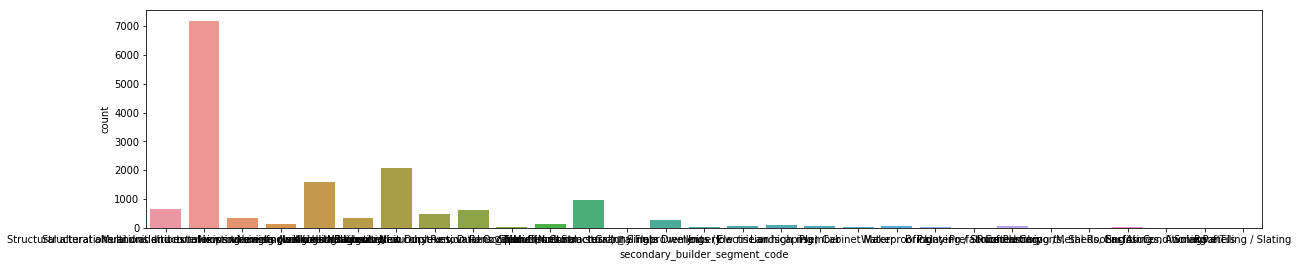

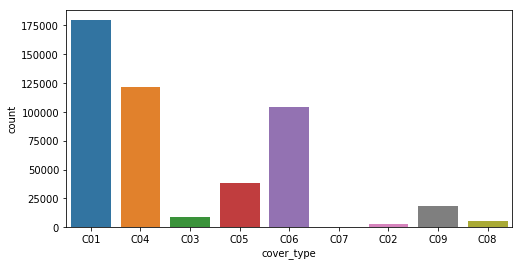

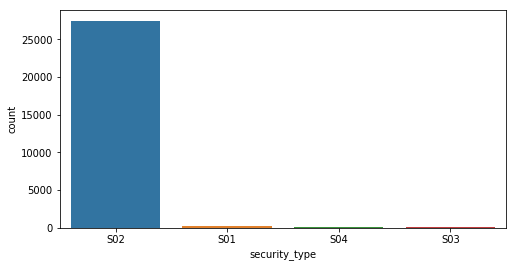

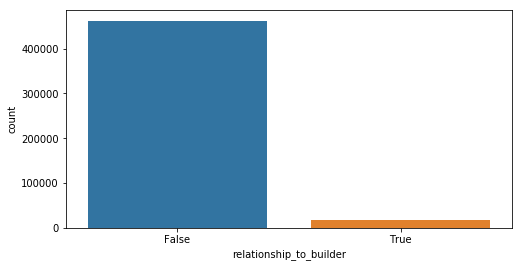

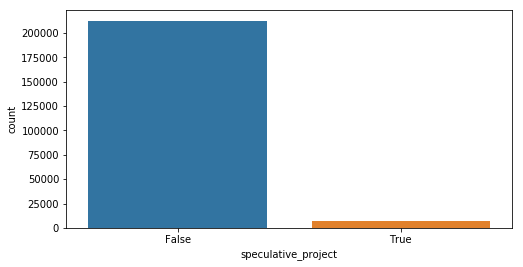

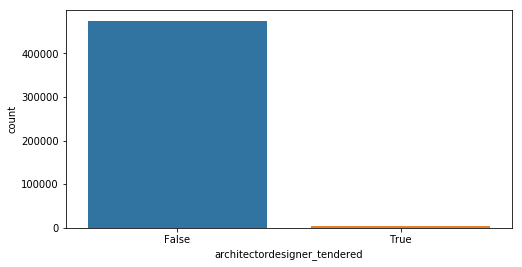

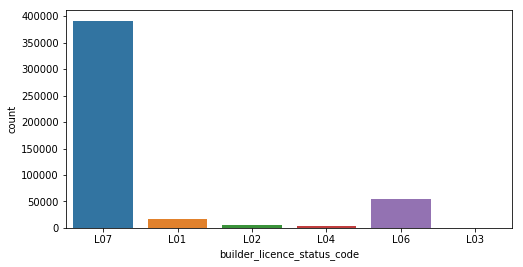

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
ax1 = sb.countplot(x='builder_entity_type', data=builder_df)
plt.figure(figsize=(20,4))
ax2 = sb.countplot(x='builder_review_size', data=builder_df)
plt.figure(figsize=(8,4))
ax3 = sb.countplot(x='builder_review_type', data=builder_df)
plt.figure(figsize=(20,4))
ax4 = sb.countplot(x='primary_builder_segment_code', data=builder_df)
plt.figure(figsize=(20,4))
ax5 = sb.countplot(x='secondary_builder_segment_code', data=builder_df)
plt.figure(figsize=(8,4))
ax = sb.countplot(x='cover_type', data=policy_builder_df)
plt.figure(figsize=(8,4))
ax = sb.countplot(x='security_type', data=policy_builder_df)
plt.figure(figsize=(8,4))
ax = sb.countplot(x='relationship_to_builder', data=policy_builder_df)
plt.figure(figsize=(8,4))
ax = sb.countplot(x='speculative_project', data=policy_builder_df)
plt.figure(figsize=(8,4))
ax = sb.countplot(x='architectordesigner_tendered', data=policy_builder_df)
plt.figure(figsize=(8,4))
ax = sb.countplot(x='builder_licence_status_code', data=policy_builder_df)

# for i in range(1,9):
#     plt.figure(figsize=(8,4))
#     ax = sb.countplot(x='c0{}_cover_yn'.format(i), data=builder_df)